<a href="https://colab.research.google.com/github/Existanze54/sirius-machine-learning-2024/blob/main/Seminars/Solutions/S5s_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оновные алгоритмы ML

### Семинар 5. Методы кросс-валидации (CV)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Использование встроенных средств sklearn

Поменяйте код из лекции для Monte-Carlo cross-validation так, чтобы он использовал <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html'>StratifiedShuffleSplit</a>

Для начала сгенерируем искусственный набор данных, как в прошлом семинаре

In [ ]:
X, Y = datasets.make_classification(n_features=2,
                                       n_redundant=0,
                                       n_informative=1,
                                       random_state=202,
                                       n_clusters_per_class=1,
                                       flip_y=0,
                                       n_samples=200)

In [ ]:
def get_monte_carlo_cv_scores(X, y, clf, n_samples,
                              test_size='random', random_state=12345):
    rng = np.random.RandomState(seed=random_state)
    seeds = np.arange(10**5)
    rng.shuffle(seeds)
    seeds = seeds[:n_samples]
    auroc_mccv = []
    if test_size == 'random':
        sizes = rng.choice(np.linspace(0.05, 0.5, 46),
                           size=n_samples, replace=True)
        for i, size in zip(seeds, sizes):
            X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                              test_size=size,
                                                              random_state=i,
                                                              stratify=y)
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            y_score = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
            auroc = roc_auc_score(y_true=y_val, y_score=y_score)
            auroc_mccv.append(auroc)
    elif isinstance(test_size, float):
        for i in seeds:
            X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                              test_size=test_size,
                                                              random_state=i,
                                                              stratify=y)
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            y_score = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
            auroc = roc_auc_score(y_true=y_val, y_score=y_score)
            auroc_mccv.append(auroc)
    else:
        return 'Wrong test_size type. Must be string ("random") or float'
    return np.array(auroc_mccv)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

In [ ]:
for train_ids, test_ids in splitter.split(X, Y):
  print(train_ids, test_ids)

[ 58   1   5 157 135 169  67  13 124  24 138  10  74  43 129  91  12 152
  59 123 133 174  26  94  79  40  70  23 100  15  98   8 170  18  88  93
  22  31  42 151 126 116 114  87 168  41  56 189 134 188  34  52  11  16
  69 164  62 149  32  28 117   4 161 160  80  50 159  72  45  75  81 195
 131  36 141 108  84 166   2  17 171 193 121 142 110 101 176 109 178  53
  35 185 144  68  95 115   9  14  71 112  57  30  27 120  60 162  96 181
 156 198  97 128 132 186 192 150 184  61 154 191  99  33 130  76 147 140
 155 199   3 119 172  47 183 177  89  55 122 167 104  49] [146 102  86  54 145  44  82 153 139 125 173  64 163 113  66  77 180  25
 103 196  48   7  39  19   0  21 182  90 190  73  29 194 105 158  78 127
 111  38  63 165  65  20 118 175  85 179 136 106  51 143   6 107  92 197
  83  46 187 137 148  37]
[105 134 130 181  88 199 155 160  91 157  86 159  28 198  57  42  30  31
  14 108  84 122  77 173  27 127 112 128  41  74 141   3  95 143  79 191
 126 102 123 147 132 140 175 151  20  17

In [ ]:
# доработанная функция

def get_monte_carlo_cv_scores(X, Y, clf, n_samples,
                              val_size=0.3, random_state=12345):

    splitter = StratifiedShuffleSplit(n_splits=n_samples,
                                      test_size=val_size,
                                      random_state=random_state)
    auroc_mccv = []
    for train_ids, val_ids in splitter.split(X, Y):
        X_train, X_val, y_train, y_val = X[train_ids], X[val_ids], Y[train_ids], Y[val_ids]
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        y_score = clf.fit(X_train, y_train).predict_proba(X_val)[:, 1]
        auroc = roc_auc_score(y_true=y_val, y_score=y_score)
        auroc_mccv.append(auroc)

    return np.array(auroc_mccv)

In [ ]:
def plot_mccv_results(auroc, title):
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(12, 6))
        plt.title(title, size=22)
        plt.bar(range(0, auroc.shape[0]), auroc, color='gray', alpha=0.7)
        plt.axhline(auroc.max(), color='k', linewidth=1, linestyle='--')
        plt.axhline(auroc.min(), color='k', linewidth=1, linestyle='--')
        plt.axhspan(auroc.min(), auroc.max(), alpha=0.2, color='steelblue')
        plt.ylim([0, auroc.max() + 0.1])
        plt.xlabel('Repetition')
        plt.ylabel('AUROC')
        plt.ylim([0.5, 1.0])
        plt.tight_layout()
        plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=100,
                                                    stratify=Y)

clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

auroc_mccv_50 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .5)
auroc_mccv_10 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .1)
auroc_mccv_random = get_monte_carlo_cv_scores(X_train, y_train, clf, 100)

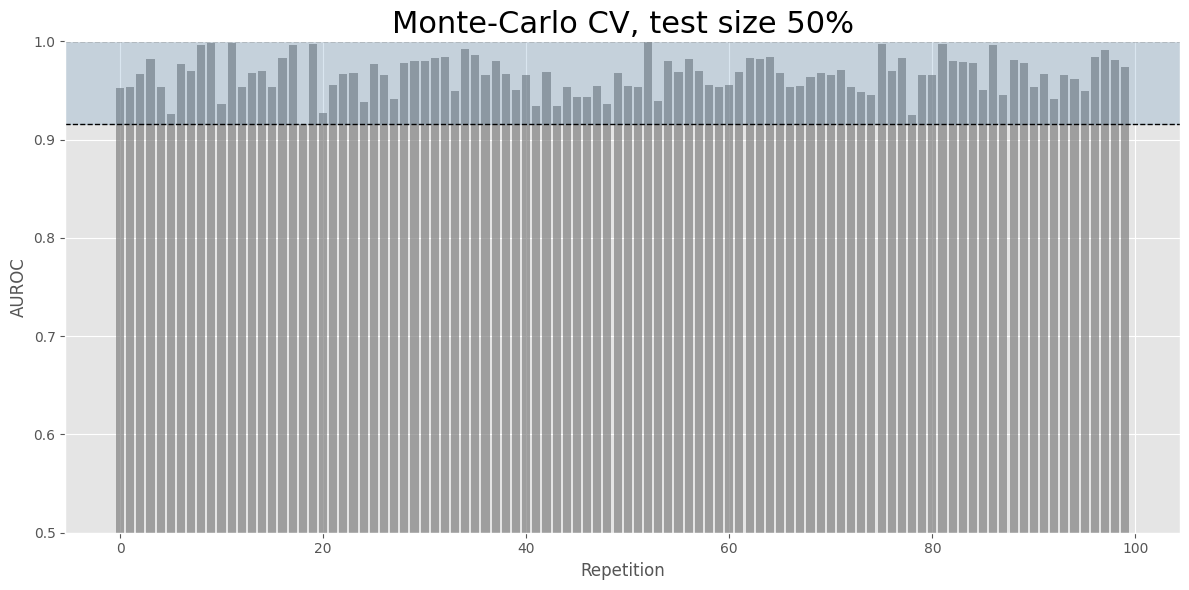

In [ ]:
plot_mccv_results(auroc_mccv_50, 'Monte-Carlo CV, test size 50%')

In [ ]:
# то же самое с другим датасетом

In [ ]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
del breast_cancer

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=100,
                                                    stratify=y)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

auroc_mccv_50 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .5)
auroc_mccv_10 = get_monte_carlo_cv_scores(X_train, y_train, clf, 100, .1)
auroc_mccv_random = get_monte_carlo_cv_scores(X_train, y_train, clf, 100)

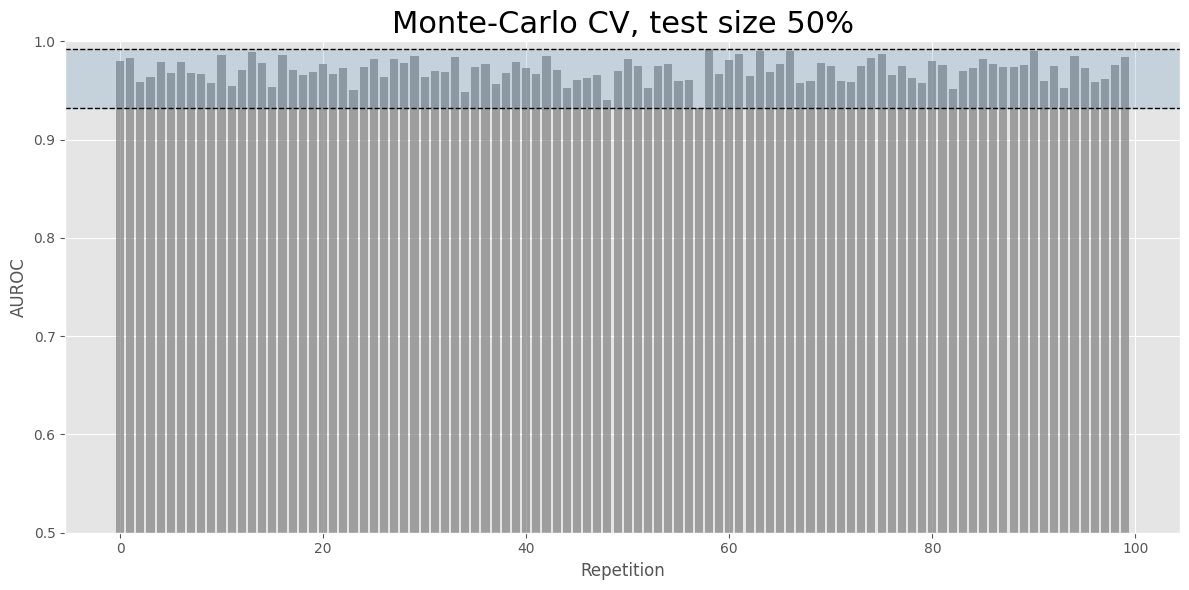

In [ ]:
plot_mccv_results(auroc_mccv_50, 'Monte-Carlo CV, test size 50%')

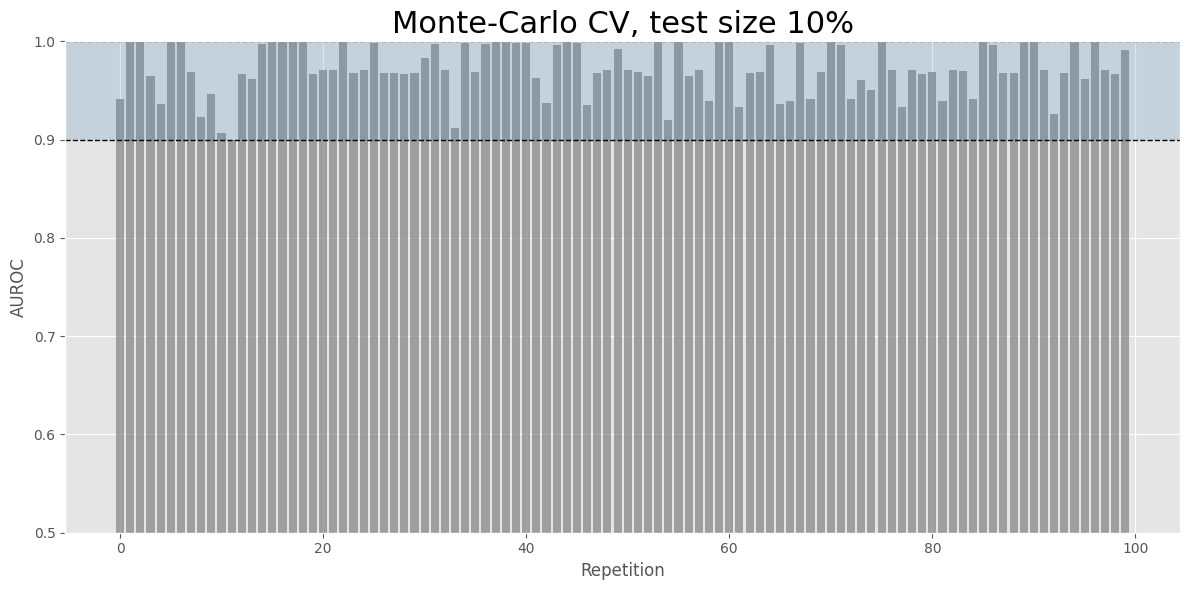

In [ ]:
plot_mccv_results(auroc_mccv_10, 'Monte-Carlo CV, test size 10%')